# UBS_lauzhack - Entity resolution model

## 1. Pre-processing

Observed the given dataset and apply the proper transformations to the data in order to better anlyse it and create the model.

In [43]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
import warnings


InteractiveShell.ast_node_interactivity = "all"
#pd.set_option('precision', 3)
display.precision = 3
sns.set()
warnings.filterwarnings('ignore')

# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
#from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox



In [44]:
# Read the CSV files from the 'data' subfolder
account_booking_df = pd.read_csv('data/account_booking_train.csv')
external_parties_df = pd.read_csv('data/external_parties_train.csv')

In [45]:
# Combine the tables with merge using 
combined_data = pd.merge(account_booking_df, external_parties_df, on='transaction_reference_id', how='inner')

In [46]:
#Null count of each variables to know which ones are more relevant to analyze
combined_data.isnull().sum()

transaction_reference_id            0
debit_credit_indicator              0
account_id                          0
transaction_amount                  0
transaction_currency                0
transaction_date                    0
party_role                          0
party_info_unstructured             0
parsed_name                         0
parsed_address_street_name        739
parsed_address_street_number     3030
parsed_address_unit             11064
parsed_address_postal_code       3480
parsed_address_city              1168
parsed_address_state             9107
parsed_address_country           6490
party_iban                       3399
party_phone                      5000
external_id                         0
dtype: int64

In [47]:
# Drop the columns that have more than 50% of missing values and irrelevant information

## External parties data

irrelevant_cols_external = ['party_info_unstructured', 'parsed_address_unit', 'parsed_address_state', 'parsed_address_country']
external_parties_df.drop(columns=irrelevant_cols_external, inplace=True, errors='ignore')

## Accounts booking data
duplicate_ids = account_booking_df[account_booking_df.duplicated(subset='transaction_reference_id', keep=False)]
account_booking_df = account_booking_df[~account_booking_df['transaction_reference_id'].isin(duplicate_ids['transaction_reference_id'])]

irrelevant_cols_booking = ['debit_credit_indicator']
account_booking_df.drop(columns=irrelevant_cols_booking, inplace=True, errors='ignore')

# Merge the two dataframes

merged_df = pd.merge(external_parties_df, account_booking_df, on='transaction_reference_id', how='inner')

merged_df.to_csv('merged_data_cleaned.csv', index=False)

In [48]:

honorifics = ['Mr. ', 'Ms. ', 'Mrs. ', 'Miss ', 'Dr. ', 'Prof. ', 'Rev. ', 'Hon. ', 'mr. ', 'ms. ', 'mrs. ', 'miss ', 'dr. ', 'prof. ', 'rev. ', 'hon. ']
for honorific in honorifics:
    merged_df['parsed_name'] = merged_df['parsed_name'].str.replace(honorific, '')


def delete_duplicates(name):
    def remove_duplicates(text):
        words = text.split()
        seen = set()
        result = []
        for word in words:
            if word.lower() not in seen:
                seen.add(word.lower())
                result.append(word)
        return ' '.join(result)
    
    name['parsed_name'] = name['parsed_name'].apply(remove_duplicates)
    return name

merged_df = delete_duplicates(merged_df)


In [49]:
from metaphone import doublemetaphone

def apply_metaphone(value):
    if isinstance(value, list) or isinstance(value, np.ndarray):  
        return np.nan  
    if pd.isna(value) or not isinstance(value, str):  
        return np.nan
    return doublemetaphone(value.strip().lower())[0] 

def split_and_metaphone(full_name):
    """
    Divide un nombre completo en sus partes (palabras), aplica Metaphone a cada parte,
    y las junta nuevamente con espacios.
    """
    if pd.isna(full_name) or not isinstance(full_name, str):  
        return np.nan

    parts = full_name.strip().split()

    return ' '.join(apply_metaphone(part) for part in parts)

merged_df['parsed_name'] = merged_df['parsed_name'].apply(split_and_metaphone)

print(merged_df['parsed_name'].head())


0          MR M0
1         ASN KM
2      RPRSN JRR
3    ASKSSNLSN K
4      MMJJ PT A
Name: parsed_name, dtype: object


In [50]:
merged_df['parsed_address_street_name'] = merged_df['parsed_address_street_name'].apply(split_and_metaphone)

print(merged_df['parsed_address_street_name'].head())

merged_df.to_csv('merged_data_cleaned.csv', index=False)

0       ANJL PRKS
1         NR0 MKL
2    RXL KRSNKPTT
3        PRTS ST 
4    JN LK SS KLN
Name: parsed_address_street_name, dtype: object


Processing block:  0r_rtr
Processing block:  ak_rt 
Processing block:  al_jsk
Processing block:  al_nn 
Processing block:  al_tlr
Processing block:  am_n n
Processing block:  ar_ant
Processing block:  as_ as
Processing block:  at_hnt
Processing block:  fr_ fr
Processing block:  hk_krs
Processing block:  hk_lrn
Processing block:  hk_mrk
Processing block:  hk_p0 
Processing block:  hk_tf 
Processing block:  hr_krs
Processing block:  hr_ls 
Processing block:  hr_m0 
Processing block:  hr_rtr
Processing block:  jn_a
Processing block:  jn_lrn
Processing block:  jn_plk
Processing block:  jn_rsl
Processing block:  jn_tms
Processing block:  jn_tnl
Processing block:  k0_jks
Processing block:  kn_rpk
Processing block:  kp_tmp
Processing block:  kr_knk
Processing block:  kr_prn
Processing block:  lr_nkl
Processing block:  m0_ kr
Processing block:  m0_ m0
Processing block:  mk_ kr
Processing block:  mk_jn 
Processing block:  mk_krs
Processing block:  mk_n l
Processing block:  mk_tn 
Processing blo

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='external_id'>

Text(0.5, 1.0, 'Distribución de Clusters')

Text(0.5, 0, 'Cluster ID')

Text(0, 0.5, 'Tamaño del Cluster')

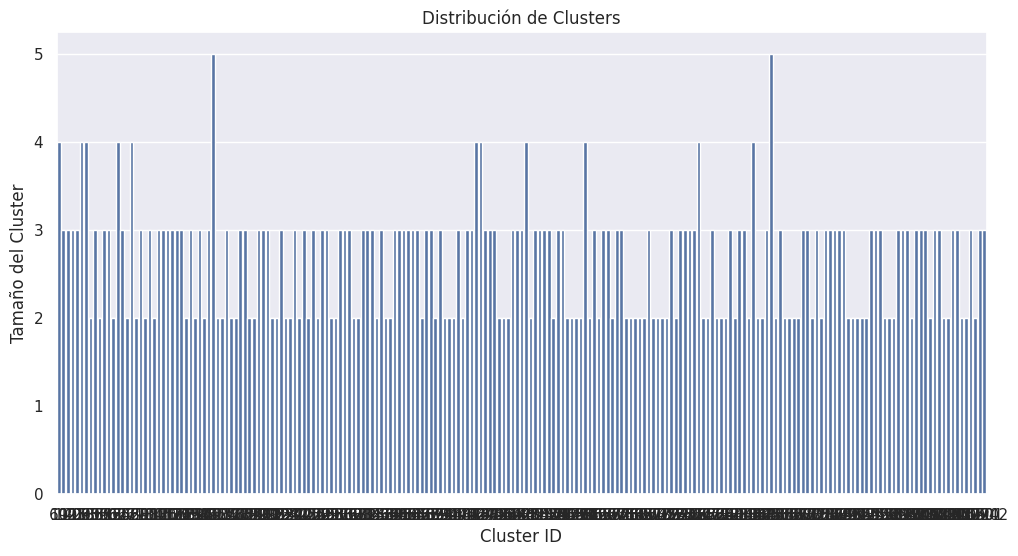

In [63]:
# Función para calcular similitudes con TF-IDF
# Reemplazar valores faltantes de direcciones
merged_df['parsed_address_street_name'].fillna(merged_df['parsed_address_city'].fillna('MISSING'), inplace=True)
def calculate_similarity(df, column1, column2):
    vectorizer = TfidfVectorizer()
    
    # Rellenamos los valores faltantes con un valor temporal
    df[column1].fillna('MISSING', inplace=True)
    df[column2].fillna('MISSING', inplace=True)
    
    # Combinamos las dos columnas en una nueva
    combined_column = df[column1] + " " + df[column2]
    
    # Creamos la matriz TF-IDF
    tfidf_matrix = vectorizer.fit_transform(combined_column)
    
    # Calculamos la matriz de similitud del coseno
    cosine_sim = cosine_similarity(tfidf_matrix)
    
    # Opcional: Penaliza similitud para valores originalmente faltantes
    missing_mask = df[column1].isna().values | df[column2].isna().values
    cosine_sim[missing_mask, :] = 0
    cosine_sim[:, missing_mask] = 0
    
    return cosine_sim


# Función de blocking
def create_block_key(value, prefix_length=5):
    if pd.isna(value):  # Maneja valores faltantes
        return 'MISSING'
    return value[:prefix_length].lower()

# Aplica el bloqueo en la columna deseada
merged_df['block'] = merged_df['parsed_name'].apply(create_block_key, prefix_length=3)

def create_combined_block(row):
    # Combina prefijos de varias columnas
    name_key = create_block_key(row['parsed_name'], prefix_length=3)
    address_key = create_block_key(row['parsed_address_street_name'], prefix_length=3)
    return f"{name_key}_{address_key}"

merged_df['block'] = merged_df.apply(create_combined_block, axis=1)
blocks = merged_df.groupby('block')


# Procesar cada bloque


merged_df['parsed_address_street_name'].fillna(
merged_df['parsed_address_city'].fillna('MISSING'), inplace=True
)

results = []

# En el bucle de procesamiento de bloques, en lugar de calcular solo la similitud de `parsed_name`, ahora usaremos las dos columnas
for block_name, block_data in blocks:
    print(f"Processing block: {block_name}")
    
    if len(block_data) < 2:
        block_data['external_id'] = range(len(results), len(results) + len(block_data))
        results.append(block_data)
        continue

    # Similaridad para 'parsed_name' y 'parsed_address_street_name'
    name_and_address_similarity = calculate_similarity(block_data, 'parsed_name', 'parsed_address_street_name')
    
    # Asegúrate de que los valores de la matriz de similitud estén en el rango [0, 1]
    name_and_address_similarity = np.clip(name_and_address_similarity, 0, 1)
    
    # Convertimos la matriz de similitud en distancias
    distance_matrix = 1 - name_and_address_similarity
    
    # Aplicamos DBSCAN
    db = DBSCAN(eps=0.3, min_samples=2, metric='precomputed')
    clusters = db.fit_predict(distance_matrix)
    
    # Asignamos clusters como 'external_id'
    block_data['external_id'] = clusters + len(results)  # Evita conflictos entre bloques
    results.append(block_data)


# Combinar los resultados de todos los bloques
final_df = pd.concat(results, ignore_index=True)
cluster_sizes = final_df['external_id'].value_counts()
valid_clusters = cluster_sizes[cluster_sizes > 1].index

# Filtramos las filas que pertenecen a esos clusters
filtered_df = final_df[final_df['external_id'].isin(valid_clusters)]
filtered_df = filtered_df[['external_id', 'transaction_reference_id']]

filtered_df.to_excel('filtered_clusters.xlsx', index=False)


plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_sizes2.index, y=cluster_sizes2.values)
plt.title('Distribución de Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Tamaño del Cluster')
plt.show()

Processing block:  0r_rtr_299
Processing block:  ak_rt _212
Processing block:  al_jsk_215
Processing block:  al_nn _217
Processing block:  al_tlr_297
Processing block:  am_n n_203
Processing block:  ar_ant_239
Processing block:  as_ as_211
Processing block:  as_ as_290
Processing block:  at_hnt_209
Processing block:  fr_ fr_288
Processing block:  hk_krs_202
Processing block:  hk_krs_245
Processing block:  hk_lrn_254
Processing block:  hk_mrk_211
Processing block:  hk_p0 _262
Processing block:  hk_tf _271
Processing block:  hr_krs_222
Processing block:  hr_ls _294
Processing block:  hr_m0 _204
Processing block:  hr_rtr_251
Processing block:  jn_a_203
Processing block:  jn_lrn_229
Processing block:  jn_plk_286
Processing block:  jn_rsl_258
Processing block:  jn_tms_284
Processing block:  jn_tnl_267
Processing block:  k0_jks_260
Processing block:  kn_rpk_234
Processing block:  kp_tmp_299
Processing block:  kr_knk_200
Processing block:  kr_prn_200
Processing block:  kr_prn_265
Processing b

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='external_id'>

Text(0.5, 1.0, 'Distribución de Clusters')

Text(0.5, 0, 'Cluster ID')

Text(0, 0.5, 'Tamaño del Cluster')

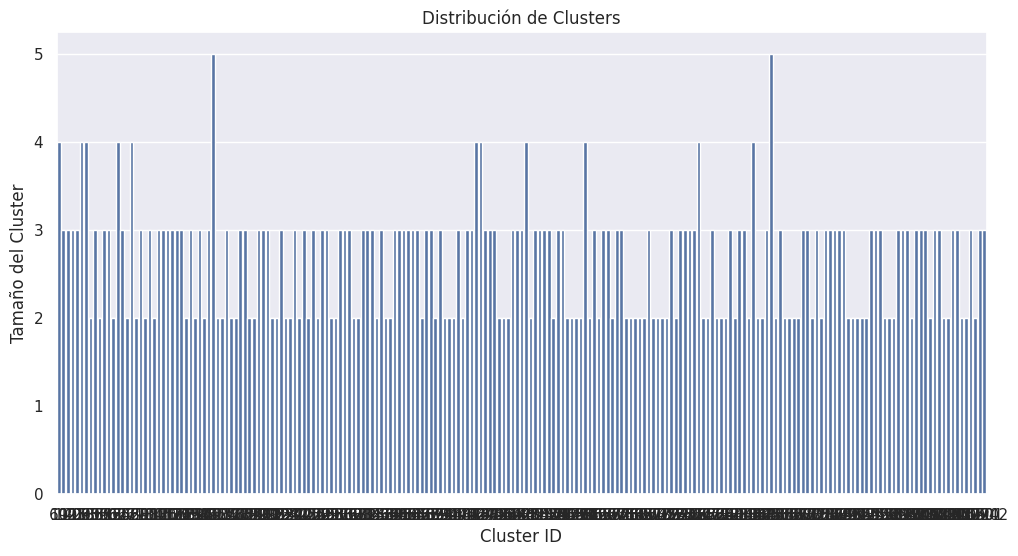

In [62]:
# Función para calcular similitudes con TF-IDF

# Reemplazar valores faltantes de direcciones
merged_df['parsed_address_street_name'].fillna(merged_df['parsed_address_city'].fillna('MISSING'), inplace=True)

def calculate_similarity(df, column1, column2, column3):
    vectorizer = TfidfVectorizer()
    
    # Rellenamos los valores faltantes con un valor temporal
    df[column1].fillna('MISSING', inplace=True)
    df[column2].fillna('MISSING', inplace=True)
    df[column3].fillna('MISSING', inplace=True)
    df[column3] = df[column3].astype(str)

    # Combinamos las dos columnas en una nueva
    combined_column = df[column1] + " " + df[column2] + " " + df[column3]
    
    # Creamos la matriz TF-IDF
    tfidf_matrix = vectorizer.fit_transform(combined_column)
    
    # Calculamos la matriz de similitud del coseno
    cosine_sim = cosine_similarity(tfidf_matrix)
    
    # Opcional: Penaliza similitud para valores originalmente faltantes
    missing_mask = df[column1].isna().values | df[column2].isna().values
    cosine_sim[missing_mask, :] = 0
    cosine_sim[:, missing_mask] = 0
    
    return cosine_sim


# Función de blocking
def create_block_key(value, prefix_length=5):
    if pd.isna(value):  # Maneja valores faltantes
        return 'MISSING'
    return value[:prefix_length].lower()

# Aplica el bloqueo en la columna deseada
merged_df['block'] = merged_df['parsed_name'].apply(create_block_key, prefix_length=3)

def create_combined_block(row):
    # Combina prefijos de varias columnas
    name_key = create_block_key(row['parsed_name'], prefix_length=3)
    address_key = create_block_key(row['parsed_address_street_name'], prefix_length=3)
    account_id = create_block_key(str(row['account_id']), prefix_length=3)
    return f"{name_key}_{address_key}_{account_id}"

merged_df['block'] = merged_df.apply(create_combined_block, axis=1)
blocks = merged_df.groupby('block')


# Procesar cada bloque


merged_df['parsed_address_street_name'].fillna(
merged_df['parsed_address_city'].fillna('MISSING'), inplace=True
)

results = []

# En el bucle de procesamiento de bloques, en lugar de calcular solo la similitud de `parsed_name`, ahora usaremos las dos columnas
for block_name, block_data in blocks:
    print(f"Processing block: {block_name}")
    
    if len(block_data) < 2:
        block_data['external_id'] = range(len(results), len(results) + len(block_data))
        results.append(block_data)
        continue

    # Similaridad para 'parsed_name' y 'parsed_address_street_name'
    name_and_address_similarity = calculate_similarity(block_data, 'parsed_name', 'parsed_address_street_name', 'account_id')
    
    # Asegúrate de que los valores de la matriz de similitud estén en el rango [0, 1]
    name_and_address_similarity = np.clip(name_and_address_similarity, 0, 1)
    
    # Convertimos la matriz de similitud en distancias
    distance_matrix = 1 - name_and_address_similarity
    
    # Aplicamos DBSCAN
    db = DBSCAN(eps=0.3, min_samples=2, metric='precomputed')
    clusters = db.fit_predict(distance_matrix)
    
    # Asignamos clusters como 'external_id'
    block_data['external_id'] = clusters + len(results)  # Evita conflictos entre bloques
    results.append(block_data)


# Combinar los resultados de todos los bloques
final_df = pd.concat(results, ignore_index=True)
cluster_sizes = final_df['external_id'].value_counts()
valid_clusters = cluster_sizes[cluster_sizes > 1].index

# Filtramos las filas que pertenecen a esos clusters
filtered_df = final_df[final_df['external_id'].isin(valid_clusters)]
filtered_df = filtered_df[['external_id', 'transaction_reference_id']]

filtered_df.to_excel('filtered_clusters.xlsx', index=False)

# Visualizar el tamaño de cada cluster
cluster_sizes2 = filtered_df['external_id'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_sizes2.index, y=cluster_sizes2.values)
plt.title('Distribución de Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Tamaño del Cluster')
plt.show()

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform

def calculate_similarity(df, column):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[column].fillna(''))
    cosine_sim = cosine_similarity(tfidf_matrix)
    return pd.DataFrame(cosine_sim, index=df.index, columns=df.index)

# Similaridad en nombres y direcciones
name_similarity = calculate_similarity(merged_df, 'parsed_name')
address_similarity = calculate_similarity(merged_df, 'parsed_address_street_name')
# Calculate similarity for numerical variable 'transaction_amount'
account_similarity = pd.DataFrame(
    1 - squareform(pdist(merged_df[['account_id']], metric='euclidean')),
    index=merged_df.index,
    columns=merged_df.index
)



In [ ]:
def create_block_key(value, prefix_length=5):
    if pd.isna(value):  # Maneja valores faltantes
        return 'MISSING'
    return value[:prefix_length].lower()

# Aplica el bloqueo en la columna deseada
merged_df['block'] = merged_df['parsed_name'].apply(create_block_key, prefix_length=3)

def create_combined_block(row):
    # Combina prefijos de varias columnas
    name_key = create_block_key(row['parsed_name'], prefix_length=3)
    address_key = create_block_key(row['parsed_address_street_name'], prefix_length=3)
    # account_key = create_block_key(str(row['account_id']), prefix_length=3)  
    return f"{name_key}_{address_key}"

merged_df['block'] = merged_df.apply(create_combined_block, axis=1)

blocks = merged_df.groupby('block')

In [54]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# # Función para calcular similitud con TF-IDF
# def calculate_similarity(df, column):
#     vectorizer = TfidfVectorizer()
#     filled_column = df[column].fillna('MISSING')  # Rellena missings temporalmente
#     tfidf_matrix = vectorizer.fit_transform(filled_column)
#     cosine_sim = cosine_similarity(tfidf_matrix)
    
#     # Opcional: Penaliza similitud para valores originalmente faltantes
#     missing_mask = df[column].isna().values
#     cosine_sim[missing_mask, :] = 0
#     cosine_sim[:, missing_mask] = 0
    
#     return cosine_sim


# # Función de blocking
# def create_block_key(value, prefix_length=5):
#     if pd.isna(value):  # Maneja valores faltantes
#         return 'MISSING'
#     return value[:prefix_length].lower()

# # Aplica el bloqueo en la columna deseada
# merged_df['block'] = merged_df['parsed_name'].apply(create_block_key, prefix_length=3)

# def create_combined_block(row):
#     # Combina prefijos de varias columnas
#     name_key = create_block_key(row['parsed_name'], prefix_length=3)
#     address_key = create_block_key(row['parsed_address_street_name'], prefix_length=3)
#     return f"{name_key}_{address_key}"

# merged_df['block'] = merged_df.apply(create_combined_block, axis=1)
# blocks = merged_df.groupby('block')


# # Procesar cada bloque


# merged_df['parsed_address_street_name'].fillna(
# merged_df['parsed_address_city'].fillna('MISSING'), inplace=True
# )

results = []

for block_name, block_data in blocks:
    print(f"Processing block: {block_name}")
    
    if len(block_data) < 2:
        # Si el bloque tiene solo un registro, lo marcamos como un singleton
        block_data['external_id'] = range(len(results), len(results) + len(block_data))
        results.append(block_data)
        continue

    # Similaridad para nombres y direcciones

    name_similarity = calculate_similarity(block_data, 'parsed_name')
    #address_similarity = calculate_similarity(block_data, 'parsed_address_street_name')
    #print(address_similarity)
    
    # Combinar las similitudes
    similarity_matrix = name_similarity #+ 0.3 * address_similarity
    
    # Asegurarse de que los valores de la matriz de similitud estén en el rango [0, 1]
    similarity_matrix = np.clip(similarity_matrix, 0, 1)
    
    # Convertimos la matriz de similitud en distancias
    distance_matrix = 1 - similarity_matrix
    
    # Aplicamos DBSCAN
    db = DBSCAN(eps=0.3, min_samples=2, metric='precomputed')
    clusters = db.fit_predict(distance_matrix)
    
    # Asignamos clusters como external_id
    block_data['external_id'] = clusters + len(results)  # Evita conflictos entre bloques
    results.append(block_data)

# Combinar los resultados de todos los bloques
final_df = pd.concat(results, ignore_index=True)

Processing block:  0r_rtr_299
Processing block:  ak_rt _212
Processing block:  al_jsk_215
Processing block:  al_nn _217
Processing block:  al_tlr_297
Processing block:  am_n n_203
Processing block:  ar_ant_239
Processing block:  as_ as_211
Processing block:  as_ as_290
Processing block:  at_hnt_209
Processing block:  fr_ fr_288
Processing block:  hk_krs_202
Processing block:  hk_krs_245
Processing block:  hk_lrn_254
Processing block:  hk_mrk_211
Processing block:  hk_p0 _262
Processing block:  hk_tf _271
Processing block:  hr_krs_222
Processing block:  hr_ls _294
Processing block:  hr_m0 _204
Processing block:  hr_rtr_251
Processing block:  jn_a_203
Processing block:  jn_lrn_229
Processing block:  jn_plk_286
Processing block:  jn_rsl_258
Processing block:  jn_tms_284
Processing block:  jn_tnl_267
Processing block:  k0_jks_260
Processing block:  kn_rpk_234
Processing block:  kp_tmp_299
Processing block:  kr_knk_200
Processing block:  kr_prn_200
Processing block:  kr_prn_265
Processing b

In [55]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Verifica las dimensiones de la matriz de similitud
print(f"Dimensiones de la matriz de similitud: {similarity_matrix.shape}")

# Asegúrate de que la matriz de similitud cubra todas las transacciones en final_df
if similarity_matrix.shape[0] != final_df.shape[0]:
    print("El número de transacciones en 'final_df' no coincide con la matriz de similitud.")
else:
    # Asegúrate de que no haya NaN en la matriz de similitud
    similarity_matrix_clean = np.nan_to_num(similarity_matrix)  # Reemplaza NaN por 0 o valor adecuado

    # Realizar PCA (reducción de dimensionalidad)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(similarity_matrix_clean)

    # Verifica que las dimensiones de reduced_data coinciden con final_df
    print(f"Dimensiones de final_df: {final_df.shape}")
    print(f"Dimensiones de reduced_data: {reduced_data.shape}")

    # Si las dimensiones coinciden, asigna las columnas PCA al DataFrame final
    if final_df.shape[0] == reduced_data.shape[0]:
        final_df['pca_x'] = reduced_data[:, 0]
        final_df['pca_y'] = reduced_data[:, 1]

        # Graficar los clusters
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=final_df,
            x='pca_x',
            y='pca_y',
            hue='external_id',  # Usar 'external_id' para los colores
            palette='viridis',
            legend=None
        )
        plt.title('Visualización de Clusters')
        plt.show()
    else:
        print("Las dimensiones de final_df y reduced_data no coinciden. Verifica la alineación de los datos.")
print(f"Dimensiones de final_df: {final_df.shape}")


Dimensiones de la matriz de similitud: (2, 2)
El número de transacciones en 'final_df' no coincide con la matriz de similitud.
Dimensiones de final_df: (11064, 15)


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='external_id'>

Text(0.5, 1.0, 'Distribución de Clusters')

Text(0.5, 0, 'Cluster ID')

Text(0, 0.5, 'Tamaño del Cluster')

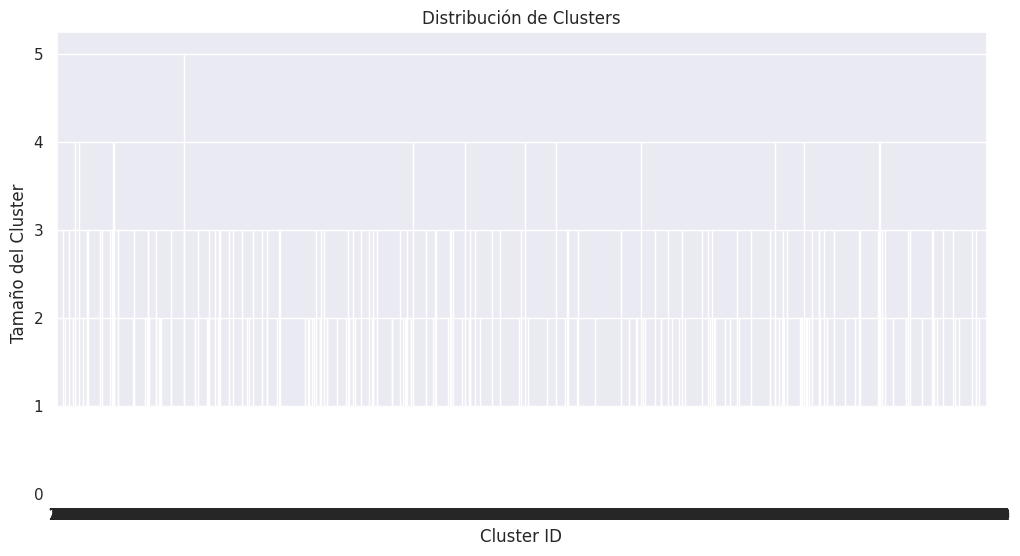

In [56]:
# Visualizar el tamaño de cada cluster
cluster_sizes = final_df['external_id'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
plt.title('Distribución de Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Tamaño del Cluster')
plt.show()


In [57]:
import jellyfish  # Para similitudes como Jaro-Winkler
from fuzzywuzzy import fuzz  # Para similitudes adicionales, si necesario

# Función para calcular similitudes entre dos nombres
def name_similarity(name1, name2):
    # Utilizamos Jaro-Winkler para calcular la similitud de los nombres
    return jellyfish.jaro_winkler(name1, name2)

# Función para calcular similitud entre dos números de teléfono
def phone_similarity(phone1, phone2):
    return phone1 == phone2  # Comparación exacta después del preprocesamiento

# Función para comparar códigos postales
def postal_code_similarity(code1, code2):
    return code1 == code2  # Comparación exacta

# Crear función para calcular similitudes generales entre los pares
def calculate_similarities(df, pairs):
    similarities = []
    
    for pair in pairs:
        idx1, idx2 = pair
        row1, row2 = df.loc[idx1], df.loc[idx2]
        
        # Calcular la similitud de nombres
        name_sim = name_similarity(row1['parsed_name'], row2['parsed_name'])
        
        # Calcular la similitud de teléfonos
        phone_sim = phone_similarity(row1['party_phone'], row2['party_phone'])
        
        # Calcular la similitud de códigos postales
        postal_sim = postal_code_similarity(row1['postal_code'], row2['postal_code'])
        
        # Podríamos ponderar las similitudes si es necesario (por ejemplo, más peso al nombre)
        total_similarity = (name_sim * 0.7) + (phone_sim * 0.2) + (postal_sim * 0.1)
        
        similarities.append(total_similarity)
    
    return similarities

# Calcular las similitudes para los pares generados
similarities = calculate_similarities(merged_df, pairs)

# Mostrar algunas de las similitudes calculadas
similarities[:10]  # Primeros 10 resultados


NameError: name 'pairs' is not defined

In [ ]:
from itertools import combinations

# Verificar si la columna block_key existe
if 'block_key' not in merged_df.columns:
    raise ValueError("La columna 'block_key' no existe en el DataFrame. Verifica tus datos.")

# Asegurarse de que no haya valores nulos en block_key
if merged_df['block_key'].isnull().any():
    raise ValueError("La columna 'block_key' contiene valores nulos. Por favor, maneja esos casos.")

# Generar pares de transacciones dentro de cada bloque
def create_pairs(df, block_column):
    pairs = []
    for key, block in df.groupby(block_column):
        block_pairs = list(combinations(block.index, 2))  # Combinaciones dentro del bloque
        pairs.extend(block_pairs)
    return pairs

# Crear los pares usando el 'block_key' fonético
pairs = create_pairs(merged_df, 'block_key')

# Mostrar algunos pares para verificar
print(f"Total de pares generados: {len(pairs)}")
print("Primeros 10 pares:")
print(pairs[:10])

ValueError: La columna 'block_key' no existe en el DataFrame. Verifica tus datos.

### 1.1 Pre-processing of the variable parsed_name

In [ ]:
# Delete honorifics from the names

# Sample data for demonstration
merged_data_cleaned2 = pd.DataFrame({
    'transaction_reference_id': [1, 2, 3, 4, 5],
    'parsed_name': ['Mr. John Doe', 'Dr. Jon Doe', 'Ms. Jane Doe', 'Jonny Doe', 'Prof. Sonya Sonya'],
    'postal_code': ['12345', '12345', '67890', '67891', '67892']
})

def delete_honorifics(name): 
    name['parsed_name'] = name['parsed_name'].str.replace('Mr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Ms. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Mrs. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Miss ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Dr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Prof. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Rev. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Hon. ', '')

delete_honorifics(merged_data_cleaned2)
print(merged_data_cleaned2)

   transaction_reference_id  parsed_name postal_code
0                         1     John Doe       12345
1                         2      Jon Doe       12345
2                         3     Jane Doe       67890
3                         4    Jonny Doe       67891
4                         5  Sonya Sonya       67892


In [ ]:
# Normalize the names

def normalize_names(name):
    name['parsed_name'] = name['parsed_name'].str.lower()

normalize_names(merged_data_cleaned2)
print(merged_data_cleaned2)

   transaction_reference_id  parsed_name postal_code
0                         1     john doe       12345
1                         2      jon doe       12345
2                         3     jane doe       67890
3                         4    jonny doe       67891
4                         5  sonya sonya       67892


In [ ]:
# Delete duplicates in the names

# Function to delete duplicated words in names
def delete_duplicates(name):
    def remove_duplicates(text):
        words = text.split()
        seen = set()
        result = []
        for word in words:
            if word.lower() not in seen:
                seen.add(word.lower())
                result.append(word)
        return ' '.join(result)
    
    name['parsed_name'] = name['parsed_name'].apply(remove_duplicates)
    return name

delete_duplicates(merged_data_cleaned2) 
print(merged_data_cleaned2)

,transaction_reference_id,parsed_name,postal_code
0,1,john doe,12345
1,2,jon doe,12345
2,3,jane doe,67890
3,4,jonny doe,67891
4,5,sonya,67892


   transaction_reference_id parsed_name postal_code
0                         1    john doe       12345
1                         2     jon doe       12345
2                         3    jane doe       67890
3                         4   jonny doe       67891
4                         5       sonya       67892


In [ ]:
print(merged_data_cleaned2.columns)


Index(['transaction_reference_id', 'parsed_name', 'postal_code'], dtype='object')


In [ ]:
import networkx as nx
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
#from jellyfish import jaro_winkler_similarity
import pandas as pd
import fuzzy

# Initialize Soundex or Metaphone
metaphone = fuzzy.nysiis  # Uncomment this line to use Metaphone

# Step 2: Indexing (blocking) using Soundex or Metaphone
def create_block_key(name):
    metaphone_code = metaphone(name)  
    return metaphone_code

# Create block keys
#merged_data_cleaned2['block_key'] = merged_data_cleaned2.apply(lambda row: create_block_key(row['parsed_name']), axis=1)

#print(merged_data_cleaned2)


ModuleNotFoundError: No module named 'networkx'

In [ ]:
def split_and_metaphone(full_name):
    """
    Divide un nombre completo en sus partes (palabras), aplica Metaphone a cada parte,
    y las junta nuevamente con espacios.
    """
    if pd.isna(full_name) or not isinstance(full_name, str):  
        return np.nan

    parts = full_name.strip().split()

    return ' '.join(create_block_key(part) for part in parts)

# Apply the function to the 'parsed_name' column
merged_data_cleaned2['block_key'] = merged_data_cleaned2['parsed_name'].apply(split_and_metaphone)
print(merged_data_cleaned2)

   transaction_reference_id parsed_name postal_code block_key
0                         1    john doe       12345     JAN D
1                         2     jon doe       12345     JAN D
2                         3    jane doe       67890     JAN D
3                         4   jonny doe       67891    JANY D
4                         5       sonya       67892       SAN


### 1.2 Phone pre-processing

In [ ]:
# Phone number normalization

combined_data['party_phone'] = combined_data['party_phone'].str.split('x').str[0]
combined_data['party_phone'] = combined_data['party_phone'].replace(r'\D', '', regex=True)
combined_data['party_phone'] = combined_data['party_phone'].str.lstrip('0')

data = combined_data[['party_phone']]
print(data)

          party_phone
0                 NaN
1        419477655328
2                 NaN
3       4119006262567
4                 NaN
...               ...
11059  13445497715686
11060   4116282024224
11061             NaN
11062             NaN
11063  51473539600789

[11064 rows x 1 columns]


In [ ]:


# Paso 3: Construcción del grafo
graph = nx.Graph()

# Agregar nodos
for idx, row in data.iterrows():
    node_id = row['transaction_reference_id']
    graph.add_node(node_id, attributes=row)

# Agregar aristas basadas en similitud
for node1, node2 in possible_pairs:  # Comparar dentro de cada bloque
    sim_name = jaro_winkler_similarity(graph.nodes[node1]['attributes']['parsed_name'],
                                       graph.nodes[node2]['attributes']['parsed_name'])
    if sim_name > 0.8:
        graph.add_edge(node1, node2)

# Paso 4: Identificar componentes conexos
clusters = list(nx.connected_components(graph))

# Paso 5: Asignar IDs de cluster
cluster_mapping = {node: cluster_id for cluster_id, cluster in enumerate(clusters) for node in cluster}
data['external_id'] = data['transaction_reference_id'].map(cluster_mapping)


KeyError: 'transaction_reference_id'